# Generating parameter lists

# 1. Setup

In [1]:
%load_ext watermark
%load_ext autoreload

import glob
import copy
import pickle

import numpy as np
import pandas as pd
import xarray as xr

import scipy.stats as stats

import regionmask as rgn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cmocean.cm as cmo

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

conda environment: cpl_ppe_co2

pandas    : 2.2.2
scipy     : 1.14.0
sys       : 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
regionmask: 0.12.1
cartopy   : 0.24.1
numpy     : 2.0.1
matplotlib: 3.9.1
cmocean   : 4.0.3
xarray    : 2024.6.0



## 1.1 Load color dictionaries

In [2]:
mpl.rcParams['figure.dpi'] = 150

with open('./top26_param_colors.pkl', 'rb') as f:
    pscs26_dict = pickle.load(f)
    pscs26 = list(pscs26_dict.values())

with open('./top12_param_colors.pkl', 'rb') as f:
    pscs12_dict = pickle.load(f)
    pscs12 = list(pscs12_dict.values())

## 1.2 Dask (if necessary)

# 2. Load data

## 2.1 Variable name

In [3]:
varname = 'EFLX_LH_TOT'

## 2.2 Master dataframe of CLM5 PPE rankings
`02_bgb_param-rank-diff-forc.ipynb`

In [4]:
clm5_rank = pd.read_csv(f'./rank/{varname}_params_rank_all.csv')
clm5_key = list(clm5_rank.columns[1:])

## 2.3 Parameter functional types

In [5]:
cat = pd.read_csv('./category.csv', header=None)
functype = list(cat[cat[1].isna()][0])
keys = cat[cat[1].notna()][1].unique()
funcdict = dict(zip(keys, functype))

pcat = dict()
for row in cat.iterrows():
    if type(row[1][1]) == str:
        key = funcdict[row[1][1]]
        if key not in pcat:
            pcat[key] = []
        pcat[key].append(row[1][0])
    
# Remove this list
pcat.pop('Processes and related parameters not included in list');

## 2.4 Daniel Kennedy's aggregated CLM5 PPE dataset

I used this dataset for converting the sparse grid to lat/lon grid

In [6]:
f = '/glade/u/home/djk2120/ppe_clean/postp/OAAT_surv.nc'
clm5 = xr.open_dataset(f)
clm5 = clm5[[s for s in list(clm5.keys()) if varname in s]]  # select variables with v in name

## 2.5 Gridded and atmos-feedback scaled CLM5 PPE
`03_bgb_expected-coupled-et.ipynb`
- need to check the global mean from my gridding vs. Daniel's aggregated dataset

In [7]:
indir = '/glade/work/bbuchovecky/CPL_PPE_CO2'

clm5_scaled = {
    'gr': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_gridded.nc'),
    'sc': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_scaled_gridded.nc'),
    'gr_zm': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_zonal.nc'),
    'sc_zm': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_scaled_zonal.nc'),
    # 'gr_gb': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_global.nc'),
    'sc_gb': xr.open_dataset(f'{indir}/select_parameters/{varname}_offline_scaled_global.nc'),
}

## 2.6 Transient CLM6 PPE
`04_bgb_transient-clm-ppe.ipynb`

In [8]:
# Load parameter settings key
clm6_key = pd.read_csv('/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/ctsm6_oaat_key.csv')

# Load postprocessed temporally averaged dataset 
in_file = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_1985-2023.nc'
clm6_tm = xr.open_dataset(in_file)

# Append key to ds
clm6_tm = clm6_tm.assign_coords(
    key=('ens', clm6_key['key'].values),
    param=('ens', clm6_key['param'].values),
    minmax=('ens', clm6_key['minmax'].values)
)
clm6_tm = clm6_tm.set_index(ens=['param', 'minmax', 'key'], append=True)
clm6_tm = clm6_tm[[v for v in clm6_tm.data_vars if v.startswith(varname)]]


# Load postprocessed timeseries dataset
in_file = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_timeseries_1901-2023.nc'
clm6_ts = xr.open_dataset(in_file)

# Append key to ds
clm6_ts = clm6_ts.assign_coords(
    key=('ens', clm6_key['key'].values),
    param=('ens', clm6_key['param'].values),
    minmax=('ens', clm6_key['minmax'].values)
)
clm6_ts = clm6_ts.set_index(ens=['param', 'minmax', 'key'], append=True)
clm6_ts = clm6_ts[[v for v in clm6_ts.data_vars if v.startswith(varname)]]

## 2.7 ILAMB datasets
`process_ilamb.py`

`05_bgb_ILAMB-comparison.ipynb`

In [9]:
ilamb_varname = 'hfls'
indir = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed'

# Zonal mean
ilamb_zm = xr.open_dataset(f'{indir}/zonal_mean/{ilamb_varname.upper()}_ZONAL_MEAN_ILAMB_2003-2009.nc')['et_itzavg_overlap']

# Global mean
ilamb_gm = {}
for f in sorted(glob.glob(indir + '/global_mean/*.nc')):
    key = f.split('/')[-1].split('_')[3]
    ilamb_gm[key] = xr.open_dataset(f)[ilamb_varname.lower()+'_'+key]

# 3. Parameter lists

many degrees of freedom with this decision
* region (global vs. biome)
* scenario/forcing (CTL2010, AF1855, AF2095, C285, C867, transient historical, differences from AF and C)
* measure (mean, standard deviation)
* functional category

example: top 10 global mean, top 5 global std, top 5 biome mean, top 5 biome std

provide parameter list -> generate plots
* CLM5 global mean for each each scenario with ILAMB
* CLM5 zonal mean (simulated and scaled) for each each scenario with ILAMB
* transient CLM6 global mean timeseries with ILAMB
* pie chart with functional categories

## 3.1 Set operations for master dataframe

In [58]:
def OR_top(df, rank, forc=None, biome=None, measure=None, do_diff_forc=False, include=[]):
    '''
    Select parameters that appear in one of the top Y rank of mean and iav at the global and biome level.
    (effectively a union)
    '''
    forc_list = ['AF2095', 'AF1855', 'C867', 'C285']
    biome_list = ['BF', 'SD', 'TmGD', 'TmRF', 'TmSF', 'TrRF', 'TrSFS', 'Tu', 'WS', 'GB']

    if do_diff_forc:
        forc_list = forc_list + ['AF2095-AF1855', 'C867-C285']
    
    if biome == 'biome':
        biome = None
        biome_list = ['BF', 'SD', 'TmGD', 'TmRF', 'TmSF', 'TrRF', 'TrSFS', 'Tu', 'WS']

    param = set(include)

    if forc is not None and biome is not None:
        if measure is None:
            param = param | set(df.loc[df[f'RNK_{forc}_{biome}_mean']<=rank].param_name.tolist())
            param = param | set(df.loc[df[f'RNK_{forc}_{biome}_iav']<=rank].param_name.tolist())
        else:
            param = param | set(df.loc[df[f'RNK_{forc}_{biome}_{measure}']<=rank].param_name.tolist())

    elif forc is not None and biome is None:
        for bm in biome_list:
            if measure is None:
                param = param | set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank].param_name.tolist())
                param = param | set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank].param_name.tolist())
            else:
                param = param | set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank].param_name.tolist())
    
    elif biome is not None and forc is None:
        for fc in forc_list:
            if measure is None:
                param = param | set(df.loc[df[f'RNK_{fc}_{biome}_mean']<=rank].param_name.tolist())
                param = param | set(df.loc[df[f'RNK_{fc}_{biome}_iav']<=rank].param_name.tolist())
            else:
                param = param | set(df.loc[df[f'RNK_{fc}_{biome}_{measure}']<=rank].param_name.tolist())
            
    else:
        for fc in forc_list:
            for bm in biome_list:
                if measure is None:
                    param = param | set(df.loc[df[f'RNK_{fc}_{bm}_mean']<=rank].param_name.tolist())
                    param = param | set(df.loc[df[f'RNK_{fc}_{bm}_iav']<=rank].param_name.tolist())
                else:
                    param = param | set(df.loc[df[f'RNK_{fc}_{bm}_{measure}']<=rank].param_name.tolist())
                    
    return df.loc[df['param_name'].isin(param)]


def AND_top(df, rank, forc=None, biome=None, measure=None, do_diff_forc=False):
    '''
    Select parameters that appear in every top Y rank of mean and iav at the global and biome level.
    (effectively an intersection)
    '''
    forc_list = ['AF2095', 'AF1855', 'C867', 'C285']
    biome_list = ['BF', 'SD', 'TmGD', 'TmRF', 'TmSF', 'TrRF', 'TrSFS', 'Tu', 'WS', 'GB']

    if do_diff_forc:
        forc_list = forc_list + ['AF2095-AF1855', 'C867-C285']
    
    if biome == 'biome':
        biome = None
        biome_list = ['BF', 'SD', 'TmGD', 'TmRF', 'TmSF', 'TrRF', 'TrSFS', 'Tu', 'WS']
    
    param = set(df['param_name'].tolist())

    if forc is not None and biome is not None:
        if measure is None:
            param = param & set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank]['param_name'].tolist())
            param = param & set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank]['param_name'].tolist())
        else:
            param = param & set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank]['param_name'].tolist())

    elif forc is not None and biome is None:
        for bm in biome_list:
            if measure is None:
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_mean']<=rank]['param_name'].tolist())
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_iav']<=rank]['param_name'].tolist())
            else:
                param = param & set(df.loc[df[f'RNK_{forc}_{bm}_{measure}']<=rank]['param_name'].tolist())
    
    elif biome is not None and forc is None:
        for fc in forc_list:
            if measure is None:
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_mean']<=rank]['param_name'].tolist())
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_iav']<=rank]['param_name'].tolist())
            else:
                param = param & set(df.loc[df[f'RNK_{fc}_{biome}_{measure}']<=rank]['param_name'].tolist())
            
    elif biome is None and forc is None:
        for fc in forc_list:
            for bm in biome_list:
                if measure is None:
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_mean']<=rank]['param_name'].tolist())
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_iav']<=rank]['param_name'].tolist())
                else:
                    param = param & set(df.loc[df[f'RNK_{fc}_{bm}_{measure}']<=rank]['param_name'].tolist())
                
    return df.loc[df['param_name'].isin(param)]

In [11]:
# forc = ['C285', 'C867', 'AF1855', 'AF2095', 'AF2095-AF1855', 'C867-C285']
# param_lim = 3
# measure = None
# biome = None

# print('\nUNION')
# print(f'measure = {measure}')
# print(f'biome = {biome}')

# union_top = dict()
# union_top_func = dict()

# for fc in forc:
#     top = OR_top(clm5_rank, param_lim, forc=fc, measure=measure, biome=biome)
#     top = top.sort_values('param_name')
#     print(f'\n--- {fc} ---')
#     print(f'top {param_lim}: nparam = {len(top)}')
#     for i in range(len(top)):
#         print(top['param_name'].iloc[i]+',', end=' ')
#     union_top[fc] = top
#     union_top_func[fc] = dict()
#     union_top_func[fc] = sort_func_type(union_top[fc], union_top_func[fc], pcat)
#     print()

# top = OR_top(clm5_rank, param_lim, forc=None, measure=measure, biome=biome, do_diff_forc=True)
# top = top.sort_values('param_name')
# print('\n--- all ---')
# print(f'top {param_lim}: nparam = {len(top)}')
# for i in range(len(top)):
#     print(top['param_name'].iloc[i]+',', end=' ')
# union_top['all'] = top
# union_top_func['all'] = dict()
# union_top_func['all'] = sort_func_type(union_top['all'], union_top_func['all'], pcat)

## 3.2 Dashboard figure function

In [59]:
# Create the color and hatch pattern dictionaries for the pie chart
pcat_cs = dict()
pcat_ht = dict()
for i, p in enumerate(sorted(pcat.keys())):
    pcat_cs[p] = list(mpl.colors.TABLEAU_COLORS.keys())[i%len(mpl.colors.TABLEAU_COLORS)]
    if i >= len(mpl.colors.TABLEAU_COLORS):
        pcat_ht[p] = '....' 
    else:
        pcat_ht[p] = None


def sort_func_type(indict, outdict, pcat):
    for c in pcat.keys():
        outdict[c] = []
        for p in indict.param_name.values:
            if p in pcat[c]:
                outdict[c].append(p)
    return outdict


# Function that plots the transient CLM6 PPE and ILAMB datasets
def plot_transient_ppe_with_ilamb(
    ax,
    highlight_params=[],
    cs_clm6=[],
    vp_xpos = 2026,
    plot_ilamb=True,
    plot_ilamb_linear_regression = False,):
    '''
    Add docstring
    '''
    if len(highlight_params) > 0:
        cs_ilamb = ['black']*len(ilamb_gm.keys())
    else:
        cs_ilamb = list(mpl.colors.TABLEAU_COLORS)

    # Plot all the CLM6 PPE ensemble members
    for i, e in enumerate(clm6_ts.ens):
        label = None
        if i == 0:
            label = 'CLM6 PPE'
        clm6_ts['EFLX_LH_TOT_global_mean'].sel(ens=e).plot(ax=ax, color='silver', alpha=0.5, lw=1, label=label, _labels=False)
    
    # Highlight the CLM6 default
    clm6_ts['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').plot(ax=ax, color='k', lw=1, ls='-', label='CLM6 default', _labels=False)
    ax.scatter(
        vp_xpos+3,
        clm6_ts['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').mean(dim='year'),
        s=15,
        marker='o',
        color='k',
    )

    # Plot the ILAMB datasets
    for i, (key, da) in enumerate(ilamb_gm.items()):
        label_ilamb = key
        ls_ilamb = '-'
        lw_ilamb = 1.5
        if len(highlight_params) > 0:
            label_ilamb = None
            ls_ilamb = (0, (5, 1))
            lw_ilamb = 1
            if i == 0:
                label_ilamb = 'ILAMB (average of annual mean time series)'
        if plot_ilamb:
            if plot_ilamb_linear_regression:
                lr = stats.linregress(da.year, da.values)
                ax.plot(da.year, lr.slope * da.year + lr.intercept, c=cs_ilamb[i], ls='--')
                print(f'{key}: m={lr.slope:.2f}, r={lr.rvalue:.2f}, p={lr.pvalue:.2f}')

            ax.plot(da.year, da, c=cs_ilamb[i], ls=ls_ilamb, lw=lw_ilamb, label=label_ilamb, zorder=100)
            ax.scatter(vp_xpos+3, da.mean(dim='year'), marker='o', s=15, edgecolor=cs_ilamb[i], facecolor='none')
        
        else:
            ax.scatter(vp_xpos+3, da.mean(dim='year'), marker='o', s=15, edgecolor=cs_ilamb[i], facecolor='none', label=label_ilamb)

    # Highlight the selected parameters
    if len(cs_clm6) == 0:
        cs_clm6 = ['tab:orange']*len(highlight_params)
    for i, p in enumerate(highlight_params):
        for m, mk in zip(['min', 'max'], ['o', 'D']):
            if m == 'min':
                label_clm6 = p
            else:
                label_clm6 = None
            clm6_ts['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=m).plot(ax=ax, color=cs_clm6[i], lw=1.5, ls='-', _labels=False)
            ax.scatter(
                vp_xpos+5,
                clm6_ts['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=m).mean(dim='year'),
                s=10,
                marker=mk,
                color=cs_clm6[i],
            )

    # Add a violin plot for the time average of the CLM6 PPE ensemble
    vp = ax.violinplot(
        clm6_ts['EFLX_LH_TOT_global_mean'].mean(dim='year'),
        [vp_xpos],
        vert=True,
        widths=15,
        side='high',
        showmeans=False,
        showextrema=True,
        showmedians=True,
    )
    vp['bodies'][0].set(facecolor='gray')
    vp['cbars'].set(linewidth=0)
    vp['cmedians'].set(linewidth=1, color='dimgray')
    vp['cmins'].set(linewidth=1, color='dimgray')
    vp['cmaxes'].set(linewidth=1, color='dimgray')

    segmed = vp['cmedians'].get_segments().copy()
    segmin = vp['cmins'].get_segments().copy()
    segmax = vp['cmaxes'].get_segments().copy()
    for smed, smin, smax in zip(segmed, segmin, segmax):
        for s in [smed, smin, smax]:
            s[0][0] = vp_xpos - 1
            s[1][0] = vp_xpos + 1
    vp['cmedians'].set_segments(segmed)
    vp['cmins'].set_segments(segmin)
    vp['cmaxes'].set_segments(segmax)

    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel('Latent Heat Flux [W m$^{-2}$]', labelpad=24)

    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', labelright=True)
    ax.set_ylabel('Latent Heat Flux [W m$^{-2}$]')

    ax.legend(loc='lower left', ncol=1, fontsize=8)
    ax.set_title('Global Mean: Transient CLM6 PPE and ILAMB', loc='left', fontsize=10, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_xlim(1898, 2035)

    return ax


# Function that generates a summary figure for the selected parameters
def summary_figure(psel, cdict, version='', to_save=False):
    ''' Generates a summary figure for the selected parameters '''
    # Create the figure
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(3, 5, figure=fig, height_ratios=[1, 1, 1.5])

    # Create subplots
    zm_ax = []
    for i in range(5):
        zm_ax.append([fig.add_subplot(gs[0, i]), fig.add_subplot(gs[1, i])])
    zm_ax = np.array(zm_ax)
    tr_ax = fig.add_subplot(gs[2, :2])
    pi_ax = fig.add_subplot(gs[2, 2:4])
    leg_ax = fig.add_subplot(gs[2, 4], frameon=False)

    ### CLM5 ZONAL MEAN ###

    # Get the ILAMB min-max range
    ilamb_max = ilamb_zm.max(dim='dataset')
    ilamb_min = ilamb_zm.min(dim='dataset')

    # CLM5 PPE forcings
    forcing = clm5_scaled['gr_zm']['EFLX_LH_TOT_gridded_mean'].exp
    forcing = [f.item() for f in forcing if f!='NDEP']

    # CLM5 PPE parameters
    param = clm5_scaled['gr_zm']['EFLX_LH_TOT_gridded_mean'].param.values

    for i, forc in zip(range(5), forcing):
        da = clm5_scaled['gr_zm']['EFLX_LH_TOT_gridded_mean'].sel(exp=forc).stack(ensemble=['param', 'minmax'])

        for j in range(2):
            if i == 0:
                zm_ax[i, j].set_ylabel('Latent Heat Flux [W m$^{-2}$]', fontsize=10)

            zm_ax[i, j].set_xlim(-60, 90)
            zm_ax[i, j].set_xticks([-60, -30, 0, 30, 60, 90])
            zm_ax[i, j].set_xticklabels([-60, -30, 0, 30, 60, 90])
            zm_ax[i, j].set_xlabel('Latitude', fontsize=10)

            # Plot the zonal mean
            if j == 0:
                zm_ax[i, j].set_ylim(0, 120)
                zm_ax[i, j].set_title('Zonal Mean: '+forc, fontsize=10, fontweight='bold', loc='left')

                # Plot the ILAMB range
                zm_ax[i, j].fill_between(
                    ilamb_zm.lat, ilamb_min, ilamb_max,
                    color='tab:blue', alpha=0.2, linewidth=0,
                    label='ILAMB range')
                
                # Plot all ensemble members
                for ens in da.ensemble:
                    da_ens = da.sel(ensemble=ens)
                    if da_ens.isel(lat=0).minmax == 'min' and da_ens.isel(lat=0).param == 'default':
                        da_ens.plot(
                            ax=zm_ax[i, j], color='silver', alpha=0.5, lw=1,
                            label='CLM5 PPE', _labels=False)
                    else:
                        da_ens.plot(
                            ax=zm_ax[i, j], color='silver', alpha=0.5, lw=1,
                            label=None, _labels=False)
                
                # Plot the selected parameters
                for p in psel:
                    if p in cdict.keys():
                        c = cdict[p]
                    else:
                        c = 'black'
                        
                    for m in ['min', 'max']:
                        da.sel(param=p, minmax=m).plot(
                            ax=zm_ax[i, j], color=c, lw=1.25,
                            label=p, _labels=False)

            # Plot the zonal mean difference
            if j == 1:
                zm_ax[i, j].set_ylim(-20, 26)
                zm_ax[i, j].set_title('Zonal Mean Difference: '+forc, fontsize=10, fontweight='bold', loc='left')
                
                # Plot all ensemble members
                for ens in da.ensemble:
                    da_ens = da.sel(ensemble=ens)
                    if da_ens.isel(lat=0).minmax != 'min' and da_ens.isel(lat=0).param != 'default':
                        (da_ens - da.sel(param='default', minmax='min')).plot(
                            ax=zm_ax[i, j], color='silver', alpha=0.5, lw=1,
                            label=None, _labels=False)
                
                # Plot the selected parameters
                for p in psel:
                    if p in cdict.keys():
                        c = cdict[p]
                    else:
                        c = 'black'

                    for m in ['min', 'max']:
                        (da.sel(param=p, minmax=m) - da.sel(param='default', minmax='min')).plot(
                            ax=zm_ax[i, j], color=c, lw=1.25,
                            label=p, _labels=False)

    # Add a legend in the last subplot
    leg_ax.set_axis_off()
    leg_ax.set_xlim(0, 1)
    leg_ax.set_ylim(0, 1)
    ynorm = 0.04
    ytop = 0.9
    for i, p in enumerate(psel):
        if p in cdict.keys():
            c = cdict[p]
        else:
            c = 'black'
        leg_ax.plot([0.1, 0.2], [ytop-ynorm*i, ytop-ynorm*i], color=c, lw=4, label=p)
        leg_ax.text(0.25, ytop-ynorm*i, p, color='black', fontsize=8)
    leg_ax.text(0.1, 0.95, f'$n=${len(psel)}', color='black', fontsize=10)

    ### CLM6 TRANSIENT MEAN ###

    # Function to sort the parameters into functional categories
    def sort_func_type(inlist, outdict, pcat):
        for c in pcat.keys():
            outdict[c] = []
            for p in inlist:
                if p in pcat[c]:
                    outdict[c].append(p)
        return outdict

    # Ensure the parameters exist for the transient CLM6 PPE 
    # and select the associated colors
    # psel_clm6 = [p for p in psel if p in clm6_tm.param.values]
    colors_clm6 = []
    psel_clm6 = []
    for p in psel:
        if p in clm6_tm.param.values:
            if len(clm6_tm.sel(param=p).minmax) == 2:
                psel_clm6.append(p)

                if p in cdict.keys():
                    colors_clm6.append(cdict[p])
                else:
                    colors_clm6.append('black')        

    # Plot the transient CLM6 PPE
    tr_ax = plot_transient_ppe_with_ilamb(
        tr_ax,
        psel_clm6,
        colors_clm6,
        plot_ilamb=False,
    )

    ### FUNCTIONAL CATEGORY PIE CHART ###

    def absolute_value(val):
        a = int(round(val / 100. * sum(sizes)))
        return a

    psel_func = dict()
    psel_func = sort_func_type(psel, psel_func, pcat)
    psel_func = {key: value for key, value in psel_func.items() if len(value) > 0}

    labels = list(sorted(psel_func.keys()))
    sizes = [len(psel_func[key]) for key in labels]
    mod_cs = [pcat_cs[key] for key in labels]
    mod_ht = [pcat_ht[key] for key in labels]

    # Create a pie chart
    wedges, texts, autotexts = pi_ax.pie(
        sizes, labels=None,
        radius=1, startangle=90,
        autopct=absolute_value, pctdistance=0.80,
        textprops={'fontsize': 10, 'color': 'k', 'fontweight': 'bold'},
        wedgeprops=dict(width=0.4, edgecolor='w'))

    for i, wedge in enumerate(wedges):
        wedge.set_hatch(mod_ht[i])
        wedge.set_facecolor(mod_cs[i])

    pi_ax.legend(
        wedges, labels, fontsize=6,
        title='Functional Categories', title_fontsize=8,
        loc='center right', bbox_to_anchor=(1.65, 0.75))

    # Adjust layout
    plt.suptitle('param_selection_'+version, x=0, y=0.98, ha='left', fontsize=16)
    plt.tight_layout()
    plt.show()

    if to_save:
        fig.savefig(f'./summary/summary_fig_param_select_{version}.png', dpi=300, bbox_inches='tight')
        print('Figure saved!')

In [13]:
# psel = ['kmax', 'fff', 'maximum_leaf_wetted_fraction', 'medlynslope', 'medlynintercept']
# cdict = pscs12_dict

# summary_figure(psel, cdict, 'arbitrary', to_save=False)

## 3.3 Create lists

### 3.3.1 Functions

In [60]:
def print_df_summary(df):
    plist = df.param_name.values.tolist()
    plist.sort()
    print(f'n = {len(plist)}')
    for p in plist:
        print(f'  {p}')
    print()

def print_set_summary(s):
    s = list(s)
    s.sort()
    print(f'n = {len(s)}')
    for p in s:
        print(f'  {p}')
    print()

def save_to_csv(df, filename):
    df.param_name.reset_index(drop=True).to_csv(filename, index=False)
    print(f'File saved: {filename}')

def remove_param(df, param):
    df = df.loc[~df.param_name.isin(param)]
    return df

pset_dict = dict()

### 3.3.2 Create individual sets

In [71]:
print('core (AF2096 | C867, GB, mean, top5)')

core5 = OR_top(clm5_rank, 5, forc='AF2095', measure='mean', biome='GB', do_diff_forc=False, include=[])
core5 = OR_top(clm5_rank, 5, forc='C867', measure='mean', biome='GB', do_diff_forc=False, include=core5.param_name.values.tolist())
core5 = remove_param(core5, ['csol_sand'])
print_df_summary(core5)

s_core5 = set(core5.param_name.values.tolist())
pset_dict['core5'] = s_core5

core (AF2096 | C867, GB, mean, top5)
n = 6
  fff
  kmax
  liq_canopy_storage_scalar
  maximum_leaf_wetted_fraction
  medlynintercept
  medlynslope



In [72]:
print('AF2096 | C867, GB, mean, top10')

core10 = OR_top(clm5_rank, 10, forc='AF2095', measure='mean', biome='GB', do_diff_forc=False, include=[])
core10 = OR_top(clm5_rank, 10, forc='C867', measure='mean', biome='GB', do_diff_forc=False, include=core10.param_name.values.tolist())
core10 = remove_param(core10, ['csol_sand'])
print_df_summary(core10)

s_core10 = set(core10.param_name.values.tolist())
pset_dict['core10'] = s_core10

AF2096 | C867, GB, mean, top10
n = 11
  fff
  frac_sat_soil_dsl_init
  jmaxb0
  kmax
  krmax
  leafcn
  liq_canopy_storage_scalar
  maximum_leaf_wetted_fraction
  medlynintercept
  medlynslope
  tpuse_sf



In [73]:
print('(+) AF2096 | C867, GB, mean, top10')
print_set_summary(s_core10 - s_core5)

(+) AF2096 | C867, GB, mean, top10
n = 5
  frac_sat_soil_dsl_init
  jmaxb0
  krmax
  leafcn
  tpuse_sf



In [74]:
print('(+) AF2096 | C867, GB, iav, top5')

df = OR_top(clm5_rank, 5, forc='AF2095', measure='iav', biome='GB', do_diff_forc=False, include=[])
df = OR_top(clm5_rank, 5, forc='C867', measure='iav', biome='GB', do_diff_forc=False, include=df.param_name.values.tolist())
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

s_core5_iav = set(df.param_name.values.tolist())
pset_dict['p_core5_iav'] = s_core5_iav

(+) AF2096 | C867, GB, iav, top5
n = 4
  d_max
  frac_sat_soil_dsl_init
  sand_pf
  tpuse_sf



In [75]:
print('(+) AF2096 | C867, GB, iav, top10')

df = OR_top(clm5_rank, 10, forc='AF2095', measure='iav', biome='GB', do_diff_forc=False, include=[])
df = OR_top(clm5_rank, 10, forc='C867', measure='iav', biome='GB', do_diff_forc=False, include=df.param_name.values.tolist())
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

s_core10_iav = set(df.param_name.values.tolist())
pset_dict['p_core10_iav'] = s_core10_iav

(+) AF2096 | C867, GB, iav, top10
n = 9
  FUN_fracfixers
  KCN
  d_max
  dleaf
  frac_sat_soil_dsl_init
  jmaxse_sf
  psi50
  sand_pf
  tpuse_sf



In [76]:
print_set_summary(s_core10_iav - s_core5_iav)

n = 5
  FUN_fracfixers
  KCN
  dleaf
  jmaxse_sf
  psi50



In [77]:
print('(+) C867-C285, GB, mean, top5')

df = OR_top(clm5_rank, 5, forc='C867-C285', measure='mean', biome='GB', do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_dco2_gb_mean_top5 = set(df.param_name.values.tolist())
pset_dict['p_dco2_gb_mean_top5'] = p_dco2_gb_mean_top5

(+) C867-C285, GB, mean, top5
n = 2
  krmax
  tpuse_sf



In [78]:
print('(+) C867-C285, GB, mean, top10')

df = OR_top(clm5_rank, 10, forc='C867-C285', measure='mean', biome='GB', do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_dco2_gb_mean_top10 = set(df.param_name.values.tolist())
pset_dict['p_dco2_gb_mean_top10'] = p_dco2_gb_mean_top10

(+) C867-C285, GB, mean, top10
n = 5
  jmaxhd
  krmax
  sand_pf
  tpu25ratio
  tpuse_sf



In [79]:
print_set_summary(p_dco2_gb_mean_top10 - p_dco2_gb_mean_top5)

n = 3
  jmaxhd
  sand_pf
  tpu25ratio



In [80]:
print('(+) C867-C285, GB, iav, top5')

df = OR_top(clm5_rank, 5, forc='C867-C285', measure='iav', biome='GB', do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_dco2_gb_iav_top5 = set(df.param_name.values.tolist())
pset_dict['p_dco2_gb_iav_top5'] = p_dco2_gb_iav_top5

(+) C867-C285, GB, iav, top5
n = 3
  FUN_fracfixers
  jmaxse_sf
  tpuse_sf



In [81]:
print('(+) C867-C285, GB, iav, top10')

df = OR_top(clm5_rank, 10, forc='C867-C285', measure='iav', biome='GB', do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_dco2_gb_iav_top10 = set(df.param_name.values.tolist())
pset_dict['p_dco2_gb_iav_top10'] = p_dco2_gb_iav_top10

(+) C867-C285, GB, iav, top10
n = 8
  FUN_fracfixers
  KCN
  interception_fraction
  jmaxb0
  jmaxhd
  jmaxse_sf
  kn_nonmyc
  tpuse_sf



In [82]:
print_set_summary(p_dco2_gb_iav_top10 - p_dco2_gb_iav_top5)

n = 5
  KCN
  interception_fraction
  jmaxb0
  jmaxhd
  kn_nonmyc



In [83]:
print('(+) AF2095-AF1855, GB, mean, top5')

df = OR_top(clm5_rank, 5, forc='AF2095-AF1855', measure='mean', biome='GB', do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_daf_gb_mean_top5 = set(df.param_name.values.tolist())
pset_dict['p_daf_gb_mean_top5'] = p_daf_gb_mean_top5

(+) AF2095-AF1855, GB, mean, top5
n = 3
  kcha
  tpuse_sf
  vcmaxhd



In [84]:
print('(+) AF2095-AF1855, GB, mean, top10')

df = OR_top(clm5_rank, 10, forc='AF2095-AF1855', measure='mean', biome='GB', do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_daf_gb_mean_top10 = set(df.param_name.values.tolist())
pset_dict['p_daf_gb_mean_top10'] = p_daf_gb_mean_top10

(+) AF2095-AF1855, GB, mean, top10
n = 8
  cpha
  jmaxhd
  kcha
  krmax
  tpuse_sf
  vcmaxha
  vcmaxhd
  vcmaxse_sf



In [85]:
print_set_summary(p_daf_gb_mean_top10 - p_daf_gb_mean_top5)

n = 5
  cpha
  jmaxhd
  krmax
  vcmaxha
  vcmaxse_sf



In [86]:
print('(+) AF2095-AF1855, GB, iav, top5')

df = OR_top(clm5_rank, 5, forc='AF2095-AF1855', measure='iav', biome='GB', do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_daf_gb_iav_top5 = set(df.param_name.values.tolist())
pset_dict['p_daf_gb_iav_top5'] = p_daf_gb_iav_top5

(+) AF2095-AF1855, GB, iav, top5
n = 4
  KCN
  kcha
  krmax
  vcmaxhd



In [87]:
print('(+) AF2095-AF1855, GB, iav, top10')

df = OR_top(clm5_rank, 10, forc='AF2095-AF1855', measure='iav', biome='GB', do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_daf_gb_iav_top10 = set(df.param_name.values.tolist())
pset_dict['p_daf_gb_iav_top10'] = p_daf_gb_iav_top10

(+) AF2095-AF1855, GB, iav, top10
n = 9
  KCN
  clay_pf
  d_max
  kcha
  krmax
  lmrhd
  vcmaxha
  vcmaxhd
  vcmaxse_sf



In [88]:
print_set_summary(p_daf_gb_iav_top10 - p_daf_gb_iav_top5)

n = 5
  clay_pf
  d_max
  lmrhd
  vcmaxha
  vcmaxse_sf



In [89]:
print('(+) C867-C285, biomes, mean, top3')

df = OR_top(clm5_rank, 3, forc='C867-C285', measure='mean', biome=None, do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_dco2_bm_mean_top3 = set(df.param_name.values.tolist())
pset_dict['p_dco2_bm_mean_top3'] = p_dco2_bm_mean_top3

(+) C867-C285, biomes, mean, top3
n = 6
  FUN_fracfixers
  d_max
  jmaxb0
  kcha
  tpuse_sf
  vcmaxha



In [90]:
print('(+) AF2095-AF1855, biomes, mean, top3')

df = OR_top(clm5_rank, 3, forc='AF2095-AF1855', measure='mean', biome=None, do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_daf_bm_mean_top3 = set(df.param_name.values.tolist())
pset_dict['p_daf_bm_mean_top3'] = p_daf_bm_mean_top3

(+) AF2095-AF1855, biomes, mean, top3
n = 11
  KCN
  cv
  d_max
  jmaxb0
  kcha
  krmax
  lmrhd
  sand_pf
  tpu25ratio
  tpuse_sf
  vcmaxhd



In [91]:
print('(+) AF2095, biomes, mean, top3')

df = OR_top(clm5_rank, 3, forc='AF2095', measure='mean', biome=None, do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_af2095_bm_mean_top3 = set(df.param_name.values.tolist())
pset_dict['p_af2095_bm_mean_top3'] = p_af2095_bm_mean_top3

(+) AF2095, biomes, mean, top3
n = 3
  jmaxb0
  jmaxb1
  krmax



In [92]:
print('(+) AF2095, biomes, mean, top5')

df = OR_top(clm5_rank, 5, forc='AF2095', measure='mean', biome=None, do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_af2095_bm_mean_top5 = set(df.param_name.values.tolist())
pset_dict['p_af2095_bm_mean_top5'] = p_af2095_bm_mean_top5

(+) AF2095, biomes, mean, top5
n = 9
  d_max
  jmaxb0
  jmaxb1
  krmax
  leafcn
  psi50
  sand_pf
  tpu25ratio
  tpuse_sf



In [93]:
print_set_summary(p_af2095_bm_mean_top5 - p_af2095_bm_mean_top3)

n = 6
  d_max
  leafcn
  psi50
  sand_pf
  tpu25ratio
  tpuse_sf



In [94]:
print('(+) C867, biomes, mean, top3')

df = OR_top(clm5_rank, 3, forc='C867', measure='mean', biome=None, do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_c867_bm_mean_top3 = set(df.param_name.values.tolist())
pset_dict['p_c867_bm_mean_top3'] = p_c867_bm_mean_top3

(+) C867, biomes, mean, top3
n = 4
  d_max
  krmax
  tpu25ratio
  tpuse_sf



In [95]:
print('(+) C867, biomes, mean, top5')

df = OR_top(clm5_rank, 5, forc='C867', measure='mean', biome=None, do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_c867_bm_mean_top5 = set(df.param_name.values.tolist())
pset_dict['p_c867_bm_mean_top5'] = p_c867_bm_mean_top5

(+) C867, biomes, mean, top5
n = 6
  cv
  d_max
  jmaxb0
  krmax
  tpu25ratio
  tpuse_sf



In [96]:
print_set_summary(p_c867_bm_mean_top5 - p_c867_bm_mean_top3)

n = 2
  cv
  jmaxb0



In [97]:
print('(+) AF2095, biomes, iav, top3')

df = OR_top(clm5_rank, 3, forc='AF2095', measure='iav', biome=None, do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_af2095_bm_iav_top3 = set(df.param_name.values.tolist())
pset_dict['p_af2095_bm_iav_top3'] = p_af2095_bm_iav_top3

(+) AF2095, biomes, iav, top3
n = 10
  cv
  d_max
  dleaf
  frac_sat_soil_dsl_init
  jmaxb1
  krmax
  leafcn
  nstem
  sand_pf
  zsno



In [98]:
print('(+) C867, biomes, iav, top3')

df = OR_top(clm5_rank, 3, forc='C867', measure='iav', biome=None, do_diff_forc=False, include=[])
df = remove_param(df, ['csol_sand']+core5.param_name.values.tolist())
print_df_summary(df)

p_c867_bm_iav_top3 = set(df.param_name.values.tolist())
pset_dict['p_c867_bm_iav_top3'] = p_c867_bm_iav_top3

(+) C867, biomes, iav, top3
n = 10
  FUN_fracfixers
  cv
  d_max
  dleaf
  frac_sat_soil_dsl_init
  jmaxb0
  jmaxb1
  slopebeta
  tpu25ratio
  tpuse_sf



### 3.3.3 Union sets together

In [99]:
for key in sorted(pset_dict.keys()):
    print(key)

core10
core5
p_af2095_bm_iav_top3
p_af2095_bm_mean_top3
p_af2095_bm_mean_top5
p_c867_bm_iav_top3
p_c867_bm_mean_top3
p_c867_bm_mean_top5
p_core10_iav
p_core5_iav
p_daf_bm_mean_top3
p_daf_gb_iav_top10
p_daf_gb_iav_top5
p_daf_gb_mean_top10
p_daf_gb_mean_top5
p_dco2_bm_mean_top3
p_dco2_gb_iav_top10
p_dco2_gb_iav_top5
p_dco2_gb_mean_top10
p_dco2_gb_mean_top5


In [100]:
all_pset = set()
for key in pset_dict.keys():
    all_pset = all_pset | pset_dict[key]

print_set_summary(all_pset)

n = 34
  FUN_fracfixers
  KCN
  clay_pf
  cpha
  cv
  d_max
  dleaf
  fff
  frac_sat_soil_dsl_init
  interception_fraction
  jmaxb0
  jmaxb1
  jmaxhd
  jmaxse_sf
  kcha
  kmax
  kn_nonmyc
  krmax
  leafcn
  liq_canopy_storage_scalar
  lmrhd
  maximum_leaf_wetted_fraction
  medlynintercept
  medlynslope
  nstem
  psi50
  sand_pf
  slopebeta
  tpu25ratio
  tpuse_sf
  vcmaxha
  vcmaxhd
  vcmaxse_sf
  zsno



## 3.4 Dashboard figures

In [101]:
# p = ['fff', 'jmaxb0', 'medlynslope', 'medlynintercept', 'maximum_leaf_wetted_fraction', 'kmax', 'leafcn', 'd_max', 'KCN', 'FUN_fracfixers', 'psi50', 'cv', 'dleaf']
# summary_figure(p, pscs12_dict, '', to_save=False)

In [ ]:
# psel = ['kmax', 'fff', 'maximum_leaf_wetted_fraction', 'medlynslope', 'medlynintercept']
# cdict = pscs12_dict
# summary_figure(psel, cdict, 'arbitrary', to_save=False)

In [102]:
# pname = 'core5'
# pset = pset_dict[pname]
# summary_figure(pset, pscs12_dict, pname, to_save=True)

In [65]:
pset_dict['core5'] | pset_dict['p_dco2_gb_mean_top5'] | pset_dict['p_daf_gb_mean_top5']

{'fff',
 'kcha',
 'kmax',
 'krmax',
 'liq_canopy_storage_scalar',
 'maximum_leaf_wetted_fraction',
 'medlynintercept',
 'medlynslope',
 'tpuse_sf',
 'vcmaxhd'}

In [103]:
# pname = 'p_dboth_both_mean_top5'
# pset = pset_dict['core5'] | pset_dict['p_dco2_gb_mean_top5'] | pset_dict['p_daf_gb_mean_top5'] | pset_dict['p_daf_bm_mean_top3'] | pset_dict['p_dco2_bm_mean_top3']
# summary_figure(pset, pscs12_dict, pname, to_save=True)

In [104]:
# pset_dict['core10'] | pset_dict['p_core10_iav']

In [105]:
# pname = 'core10_core10_iav'
# pset = pset_dict['core10'] | pset_dict['p_core10_iav']
# summary_figure(pset, pscs12_dict, pname, to_save=False)

In [106]:
# pname = 'p_daf_gb_mean_top5'
# pset = pset_dict['core5'] | pset_dict[pname]
# summary_figure(pset, pscs12_dict, pname, to_save=True)

## 3.5 Final selection

In [107]:
pfinal = [
    'fff',
    'jmaxb0',
    'medlynslope',
    'medlynintercept',
    'maximum_leaf_wetted_fraction',
    'kmax',
    'leafcn',
    'd_max',
    'psi50',
    'cv',
    'dleaf',
    'KCN',
    'FUN_fracfixers',
    'lmrha',
    # 'ACCLIM_SF',
    # 'SOIL_HYDRO',
]
print(len(pfinal))

14


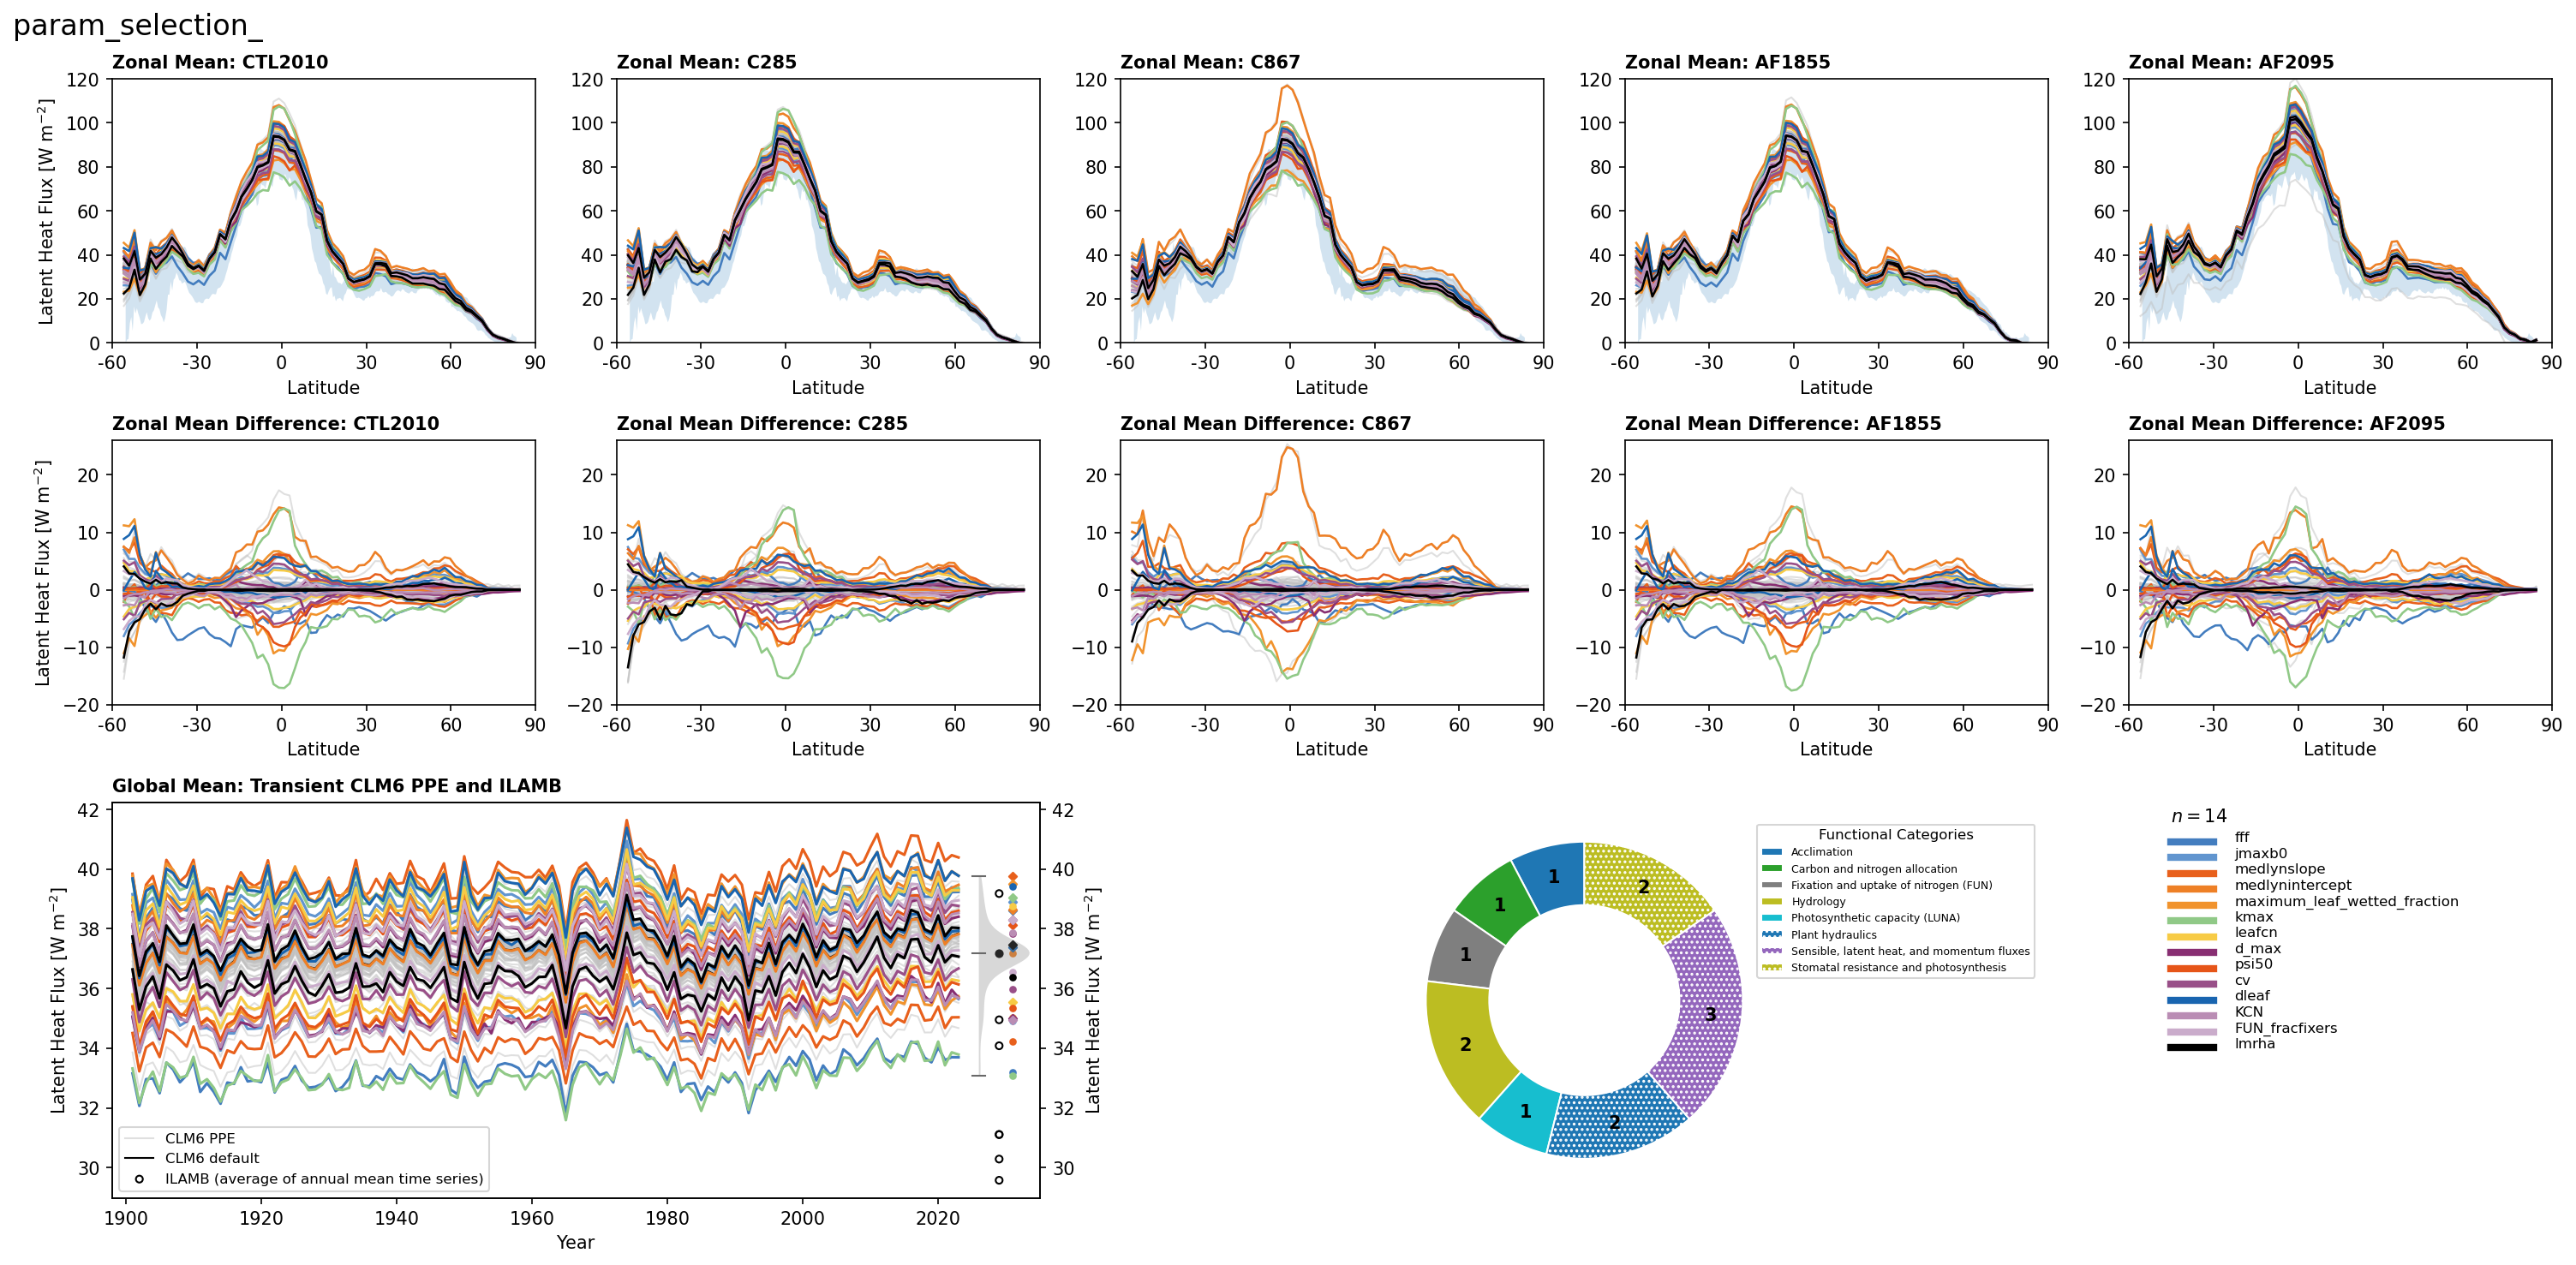

In [15]:
summary_figure(pfinal, pscs26_dict, '', to_save=False)

In [67]:
tmp.loc[tmp['param_name']=='kmax']

param_name        BF        SD   TmGD      TmRF      TmSF       TrRF  \
84       kmax  5.354325  0.835182  0.895  8.616282  9.796007  35.453769   

        TrSFS        Tu        WS        GB  
84  14.325665  2.679225  3.318651  7.009082

In [70]:
abs(clm5.EFLX_LH_TOT_biome_mean.sel(minmax='max') - clm5.EFLX_LH_TOT_biome_mean.sel(minmax='min')).sel(param='kmax', exp='AF2095').values

array([1.95962709e-03, 3.54537693e+01, 1.43256646e+01, 8.35181943e-01,
       8.61628214e+00, 9.79600677e+00, 3.31865146e+00, 8.95000379e-01,
       5.35432456e+00, 2.67922459e+00])

# 4. Individual plots

## 4.1 Transient CLM6 PPE

In [10]:
def plot_transient_ppe_with_ilamb_orig(
    highlight_params=[],
    cs_clm6=[],
    vp_xpos = 2026,
    plot_ilamb=True,
    plot_ilamb_linear_regression = False,):
    '''
    Add docstring
    '''

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    if len(highlight_params) > 0:
        cs_ilamb = ['black']*len(ilamb_gm.keys())
    else:
        cs_ilamb = list(mpl.colors.TABLEAU_COLORS)

    # Plot all the CLM6 PPE ensemble members
    for i, e in enumerate(clm6_ts.ens):
        label = None
        if i == 0:
            label = 'CLM6 PPE'
        clm6_ts['EFLX_LH_TOT_global_mean'].sel(ens=e).plot(ax=ax, color='silver', alpha=0.5, lw=1, label=label, _labels=False)
    
    # Highlight the CLM6 default
    clm6_ts['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').plot(ax=ax, color='k', lw=1, ls='-', label='CLM6 default', _labels=False)
    ax.scatter(
        vp_xpos+3,
        clm6_ts['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').mean(dim='year'),
        s=15,
        marker='o',
        color='k',
    )

    # Plot the ILAMB datasets
    for i, (key, da) in enumerate(ilamb_gm.items()):
        label_ilamb = key
        ls_ilamb = '-'
        lw_ilamb = 1.5
        if len(highlight_params) > 0:
            label_ilamb = None
            ls_ilamb = (0, (5, 1))
            lw_ilamb = 1
            if i == 0:
                label_ilamb = 'ILAMB (average of annual mean time series)'
        if plot_ilamb:
            if plot_ilamb_linear_regression:
                lr = stats.linregress(da.year, da.values)
                ax.plot(da.year, lr.slope * da.year + lr.intercept, c=cs_ilamb[i], ls='--')
                print(f'{key}: m={lr.slope:.2f}, r={lr.rvalue:.2f}, p={lr.pvalue:.2f}')

            ax.plot(da.year, da, c=cs_ilamb[i], ls=ls_ilamb, lw=lw_ilamb, label=label_ilamb, zorder=100)
            ax.scatter(vp_xpos+3, da.mean(dim='year'), marker='o', s=15, edgecolor=cs_ilamb[i], facecolor='none')
        
        else:
            ax.scatter(vp_xpos+3, da.mean(dim='year'), marker='o', s=15, edgecolor=cs_ilamb[i], facecolor='none', label=label_ilamb)

    # Highlight the selected parameters
    if len(cs_clm6) == 0:
        cs_clm6 = ['tab:orange']*len(highlight_params)
    for i, p in enumerate(highlight_params):
        for m, mk in zip(['min', 'max'], ['o', 'D']):
            if m == 'min':
                label_clm6 = p
            else:
                label_clm6 = None
            clm6_ts['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=m).plot(ax=ax, color=cs_clm6[i], lw=1.5, ls='-', label=label_clm6, _labels=False)
            ax.scatter(
                vp_xpos+5,
                clm6_ts['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=m).mean(dim='year'),
                s=10,
                marker=mk,
                color=cs_clm6[i],
            )

    # Add a violin plot for the time average of the CLM6 PPE ensemble
    vp = ax.violinplot(
        clm6_ts['EFLX_LH_TOT_global_mean'].mean(dim='year'),
        [vp_xpos],
        vert=True,
        widths=15,
        side='high',
        showmeans=False,
        showextrema=True,
        showmedians=True,
    )
    vp['bodies'][0].set(facecolor='gray')
    vp['cbars'].set(linewidth=0)
    vp['cmedians'].set(linewidth=1, color='dimgray')
    vp['cmins'].set(linewidth=1, color='dimgray')
    vp['cmaxes'].set(linewidth=1, color='dimgray')

    segmed = vp['cmedians'].get_segments().copy()
    segmin = vp['cmins'].get_segments().copy()
    segmax = vp['cmaxes'].get_segments().copy()
    for smed, smin, smax in zip(segmed, segmin, segmax):
        for s in [smed, smin, smax]:
            s[0][0] = vp_xpos - 1
            s[1][0] = vp_xpos + 1
    vp['cmedians'].set_segments(segmed)
    vp['cmins'].set_segments(segmin)
    vp['cmaxes'].set_segments(segmax)

    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', labelright=True)

    ax.legend(loc='lower left', ncol=2, fontsize=8)
    ax.set_title('global mean latent heat flux: transient CLM6 PPE and ILAMB datasets', loc='left', fontsize=10)
    ax.set_ylabel('latent heat flux [W m$^{-2}$]')
    ax.set_xlabel('year')
    ax.set_xlim(1898, 2035)

    return fig, ax

In [14]:
## Version for use in the summary figure!!
def plot_transient_ppe_with_ilamb(
    ax,
    highlight_params=[],
    cs_clm6=[],
    vp_xpos = 2026,
    plot_ilamb=True,
    plot_ilamb_linear_regression = False,):
    '''
    Add docstring
    '''
    if len(highlight_params) > 0:
        cs_ilamb = ['black']*len(ilamb_gm.keys())
    else:
        cs_ilamb = list(mpl.colors.TABLEAU_COLORS)

    # Plot all the CLM6 PPE ensemble members
    for i, e in enumerate(clm6_ts.ens):
        label = None
        if i == 0:
            label = 'CLM6 PPE'
        clm6_ts['EFLX_LH_TOT_global_mean'].sel(ens=e).plot(ax=ax, color='silver', alpha=0.5, lw=1, label=label, _labels=False)
    
    # Highlight the CLM6 default
    clm6_ts['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').plot(ax=ax, color='k', lw=1, ls='-', label='CLM6 default', _labels=False)
    ax.scatter(
        vp_xpos+3,
        clm6_ts['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').mean(dim='year'),
        s=15,
        marker='o',
        color='k',
    )

    # Plot the ILAMB datasets
    for i, (key, da) in enumerate(ilamb_gm.items()):
        label_ilamb = key
        ls_ilamb = '-'
        lw_ilamb = 1.5
        if len(highlight_params) > 0:
            label_ilamb = None
            ls_ilamb = (0, (5, 1))
            lw_ilamb = 1
            if i == 0:
                label_ilamb = 'ILAMB (average of annual mean time series)'
        if plot_ilamb:
            if plot_ilamb_linear_regression:
                lr = stats.linregress(da.year, da.values)
                ax.plot(da.year, lr.slope * da.year + lr.intercept, c=cs_ilamb[i], ls='--')
                print(f'{key}: m={lr.slope:.2f}, r={lr.rvalue:.2f}, p={lr.pvalue:.2f}')

            ax.plot(da.year, da, c=cs_ilamb[i], ls=ls_ilamb, lw=lw_ilamb, label=label_ilamb, zorder=100)
            ax.scatter(vp_xpos+3, da.mean(dim='year'), marker='o', s=15, edgecolor=cs_ilamb[i], facecolor='none')
        
        else:
            ax.scatter(vp_xpos+3, da.mean(dim='year'), marker='o', s=15, edgecolor=cs_ilamb[i], facecolor='none', label=label_ilamb)

    # Highlight the selected parameters
    if len(cs_clm6) == 0:
        cs_clm6 = ['tab:orange']*len(highlight_params)
    for i, p in enumerate(highlight_params):
        for m, mk in zip(['min', 'max'], ['o', 'D']):
            if m == 'min':
                label_clm6 = p
            else:
                label_clm6 = None
            clm6_ts['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=m).plot(ax=ax, color=cs_clm6[i], lw=1.5, ls='-', _labels=False)
            ax.scatter(
                vp_xpos+5,
                clm6_ts['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=m).mean(dim='year'),
                s=10,
                marker=mk,
                color=cs_clm6[i],
            )

    # Add a violin plot for the time average of the CLM6 PPE ensemble
    vp = ax.violinplot(
        clm6_ts['EFLX_LH_TOT_global_mean'].mean(dim='year'),
        [vp_xpos],
        vert=True,
        widths=15,
        side='high',
        showmeans=False,
        showextrema=True,
        showmedians=True,
    )
    vp['bodies'][0].set(facecolor='gray')
    vp['cbars'].set(linewidth=0)
    vp['cmedians'].set(linewidth=1, color='dimgray')
    vp['cmins'].set(linewidth=1, color='dimgray')
    vp['cmaxes'].set(linewidth=1, color='dimgray')

    segmed = vp['cmedians'].get_segments().copy()
    segmin = vp['cmins'].get_segments().copy()
    segmax = vp['cmaxes'].get_segments().copy()
    for smed, smin, smax in zip(segmed, segmin, segmax):
        for s in [smed, smin, smax]:
            s[0][0] = vp_xpos - 1
            s[1][0] = vp_xpos + 1
    vp['cmedians'].set_segments(segmed)
    vp['cmins'].set_segments(segmin)
    vp['cmaxes'].set_segments(segmax)

    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel('Latent Heat Flux [W m$^{-2}$]', labelpad=24)

    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', labelright=True)
    ax.set_ylabel('Latent Heat Flux [W m$^{-2}$]')
    
    if len(highlight_params) > 0:
        ax.legend(loc='lower left', ncol=1, fontsize=8)
    else:
        ax.legend(loc='lower left', ncol=2, fontsize=8)
    ax.set_title('Global Mean: Transient CLM6 PPE and ILAMB', loc='left', fontsize=10, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_xlim(1898, 2035)

    return ax

In [15]:
# np.unique(clm6_ts['EFLX_LH_TOT_global_mean'].param)

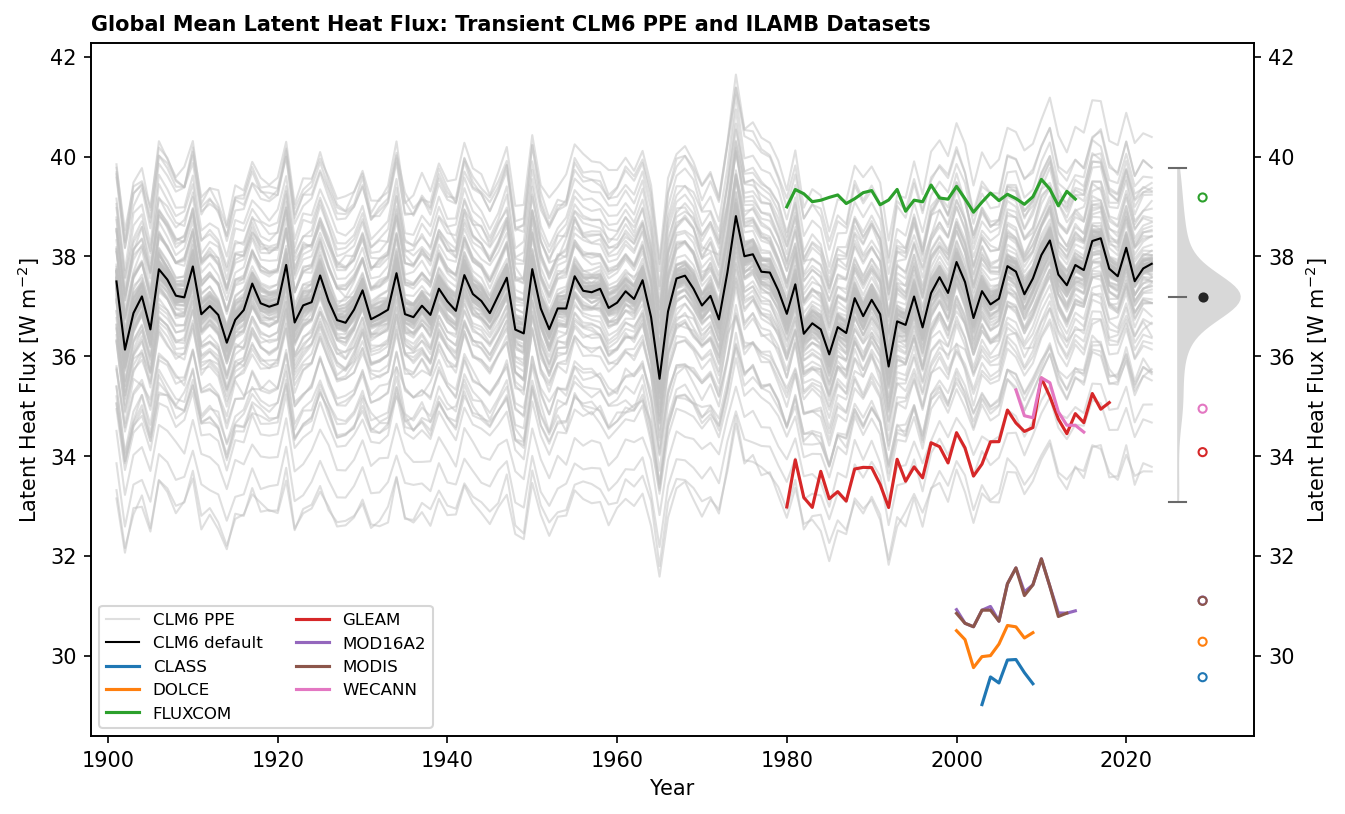

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = plot_transient_ppe_with_ilamb(ax)
ax.set_title('Global Mean Latent Heat Flux: Transient CLM6 PPE and ILAMB Datasets', loc='left', fontsize=10, fontweight='bold')
fig.savefig('./ilamb/transient_clm6_ppe_ilamb.png', bbox_inches='tight', dpi=400)

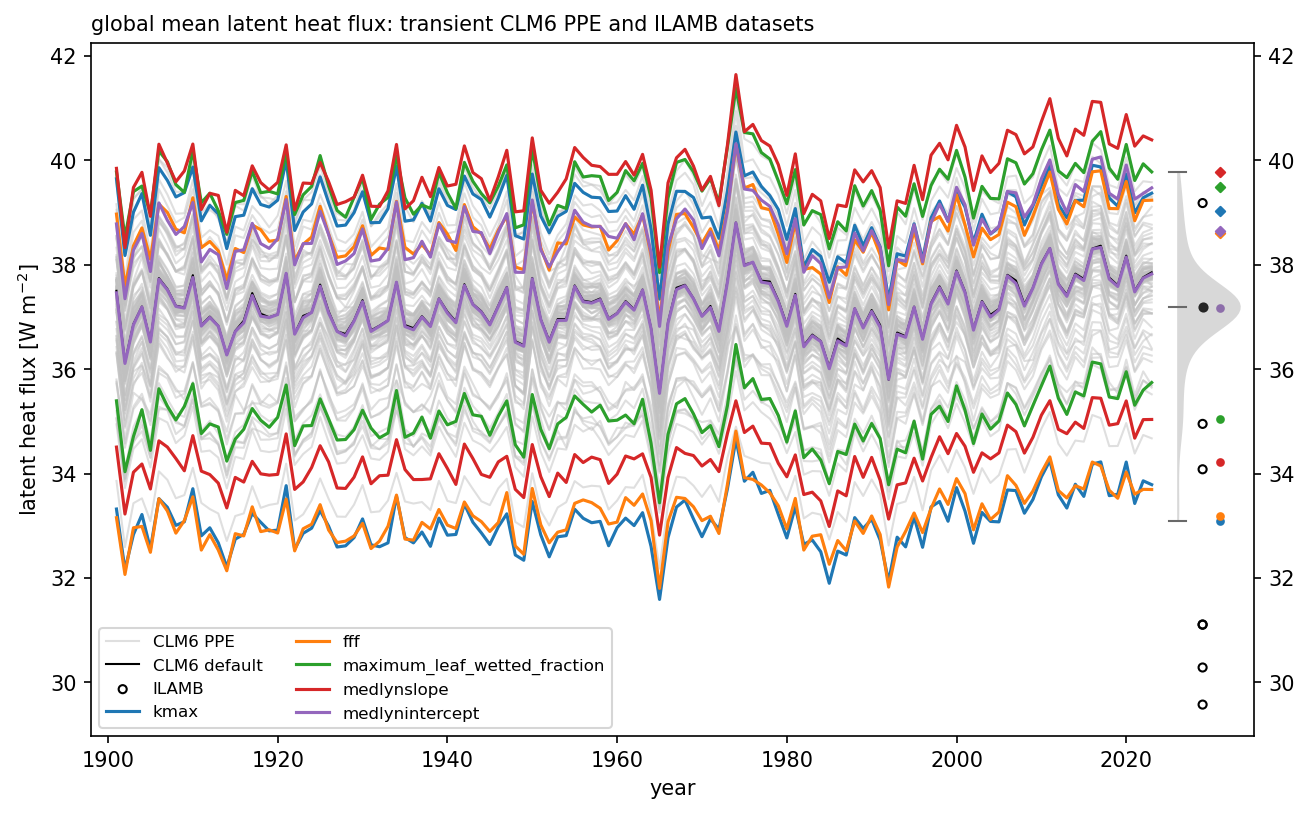

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = plot_transient_ppe_with_ilamb_orig(
    ax,
    ['kmax', 'fff', 'maximum_leaf_wetted_fraction', 'medlynslope', 'medlynintercept'],
    list(mpl.colors.TABLEAU_COLORS),
    plot_ilamb=False,
)
# fig.savefig('./ilamb/transient_clm6_ppe_ilamb_highlight_params.png', bbox_inches='tight', dpi=400)

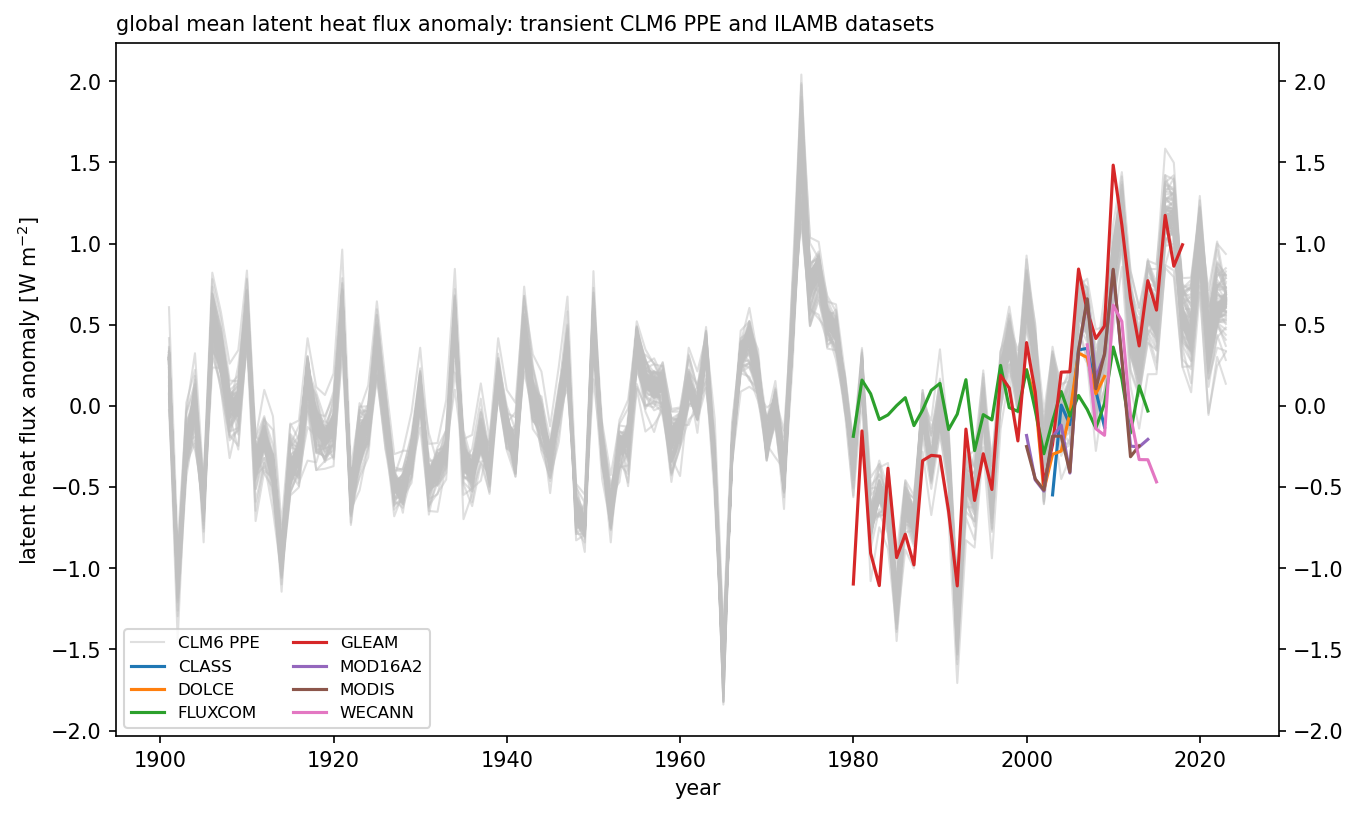

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cs = list(mpl.colors.TABLEAU_COLORS)

for i, e in enumerate(clm6_ts.ens):
    label = None
    if i == 0:
        label = 'CLM6 PPE'
    (clm6_ts['EFLX_LH_TOT_global_mean'].sel(ens=e) - clm6_ts['EFLX_LH_TOT_global_mean'].sel(ens=e).mean(dim='year')).plot(ax=ax, color='silver', alpha=0.5, lw=1, label=label, _labels=False)

for i, (key, da) in enumerate(ilamb_gm.items()):
    lr = stats.linregress(da.year, da.values)
    ax.plot(da.year, da - da.mean(dim='year'), c=cs[i], label=f'{key}')

ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', labelright=True)

ax.legend(loc='lower left', ncol=2, fontsize=8)
ax.set_title('global mean latent heat flux anomaly: transient CLM6 PPE and ILAMB datasets', loc='left', fontsize=10)
ax.set_ylabel('latent heat flux anomaly [W m$^{-2}$]')
ax.set_xlabel('year')

fig.savefig('./ilamb/transient_clm6_ppe_ilamb_anomaly.png', bbox_inches='tight', dpi=400)

## 4.2. CLM5 zonal mean

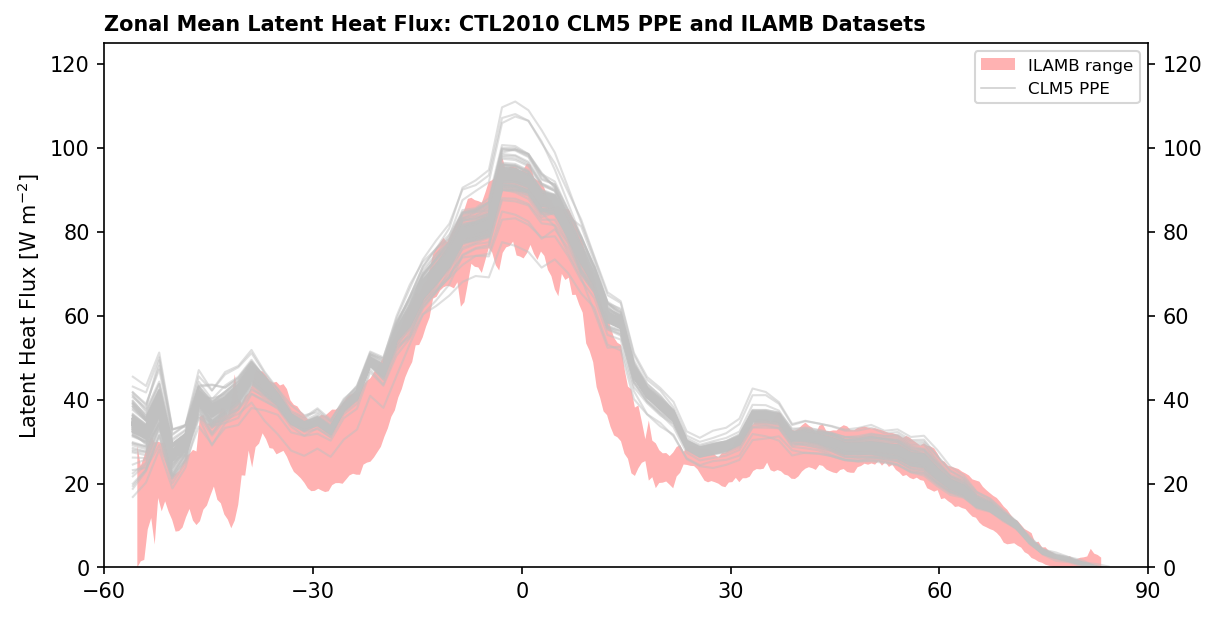

In [34]:
plot_quantiles = False

fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout='constrained')

# Get the ILAMB min-max range
ilamb_max = ilamb_zm.max(dim='dataset')
ilamb_min = ilamb_zm.min(dim='dataset')

ax.fill_between(
    ilamb_zm.lat, ilamb_min, ilamb_max,
    color='red', alpha=0.3, linewidth=0,
    label='ILAMB range')

forc = 'CTL2010'
kind = 'gr_zm'

# Select the CLM5 PPE data
if kind=='gr_zm': tag = ''
else: tag = '_scaled'
da = clm5_scaled[kind]['EFLX_LH_TOT_gridded_mean'+tag].sel(exp=forc).stack(ensemble=['param', 'minmax'])

# Plot the CLM5 PPE quantiles, min, and max
if plot_quantiles:
    defqs = [0.005, 0.01, 0.05, 0.95, 0.99, 0.995]
    qs = np.zeros((len(defqs), len(da.lat)))
    for k, q in enumerate(defqs):
        qs[k] = da.quantile(q, dim='ensemble', skipna=True).values;
    qmin = da.min(dim='ensemble')
    qmax = da.max(dim='ensemble')

    for k in range(int(len(defqs)/2)):
        if k == 0:
            ax.fill_between(
                da.lat, qs[k], qs[-k-1],
                color='red', alpha=0.2, lw=0,
                label=f'PPE quantile ranges\n(0.05-0.95, 0.01-0.99, 0.005-0.995)')
        else:
            ax.fill_between(
                da.lat, qs[k], qs[-k-1],
                color='tab:red', alpha=0.5, lw=0)
    ax.plot(da.lat, qmin, color='red', lw=1, ls=':', label='PPE extrema')
    ax.plot(da.lat, qmax, color='red', lw=1, ls=':')

# Plot the CLM5 PPE ensemble members
if not plot_quantiles:
    for ens in da.ensemble:
        da_ens = da.sel(ensemble=ens)
        if da_ens.isel(lat=0).minmax == 'min' and da_ens.isel(lat=0).param == 'default':
            da_ens.plot(
                ax=ax, color='black', alpha=0.2, lw=0.75,
                label='CLM5 PPE', _labels=False)
            
        else:
            da_ens.plot(
                ax=ax, color='silver', alpha=0.5, lw=1,
                label=None, _labels=False)

# Format the y-axis
ax.set_ylim(0, 125)
# ax.yaxis.set_label_position('right')
ax.tick_params(axis='y', labelright=True)
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Latent Heat Flux [W m$^{-2}$]')

# Format the x-axis
ax.set_xlim(-60, 90)
ax.set_xticks([-60, -30, 0, 30, 60, 90])

ax.set_title('Zonal Mean Latent Heat Flux: CTL2010 CLM5 PPE and ILAMB Datasets', loc='left', fontsize=10, fontweight='bold')

# Add a legend
ax.legend(loc='upper right', fontsize=8)

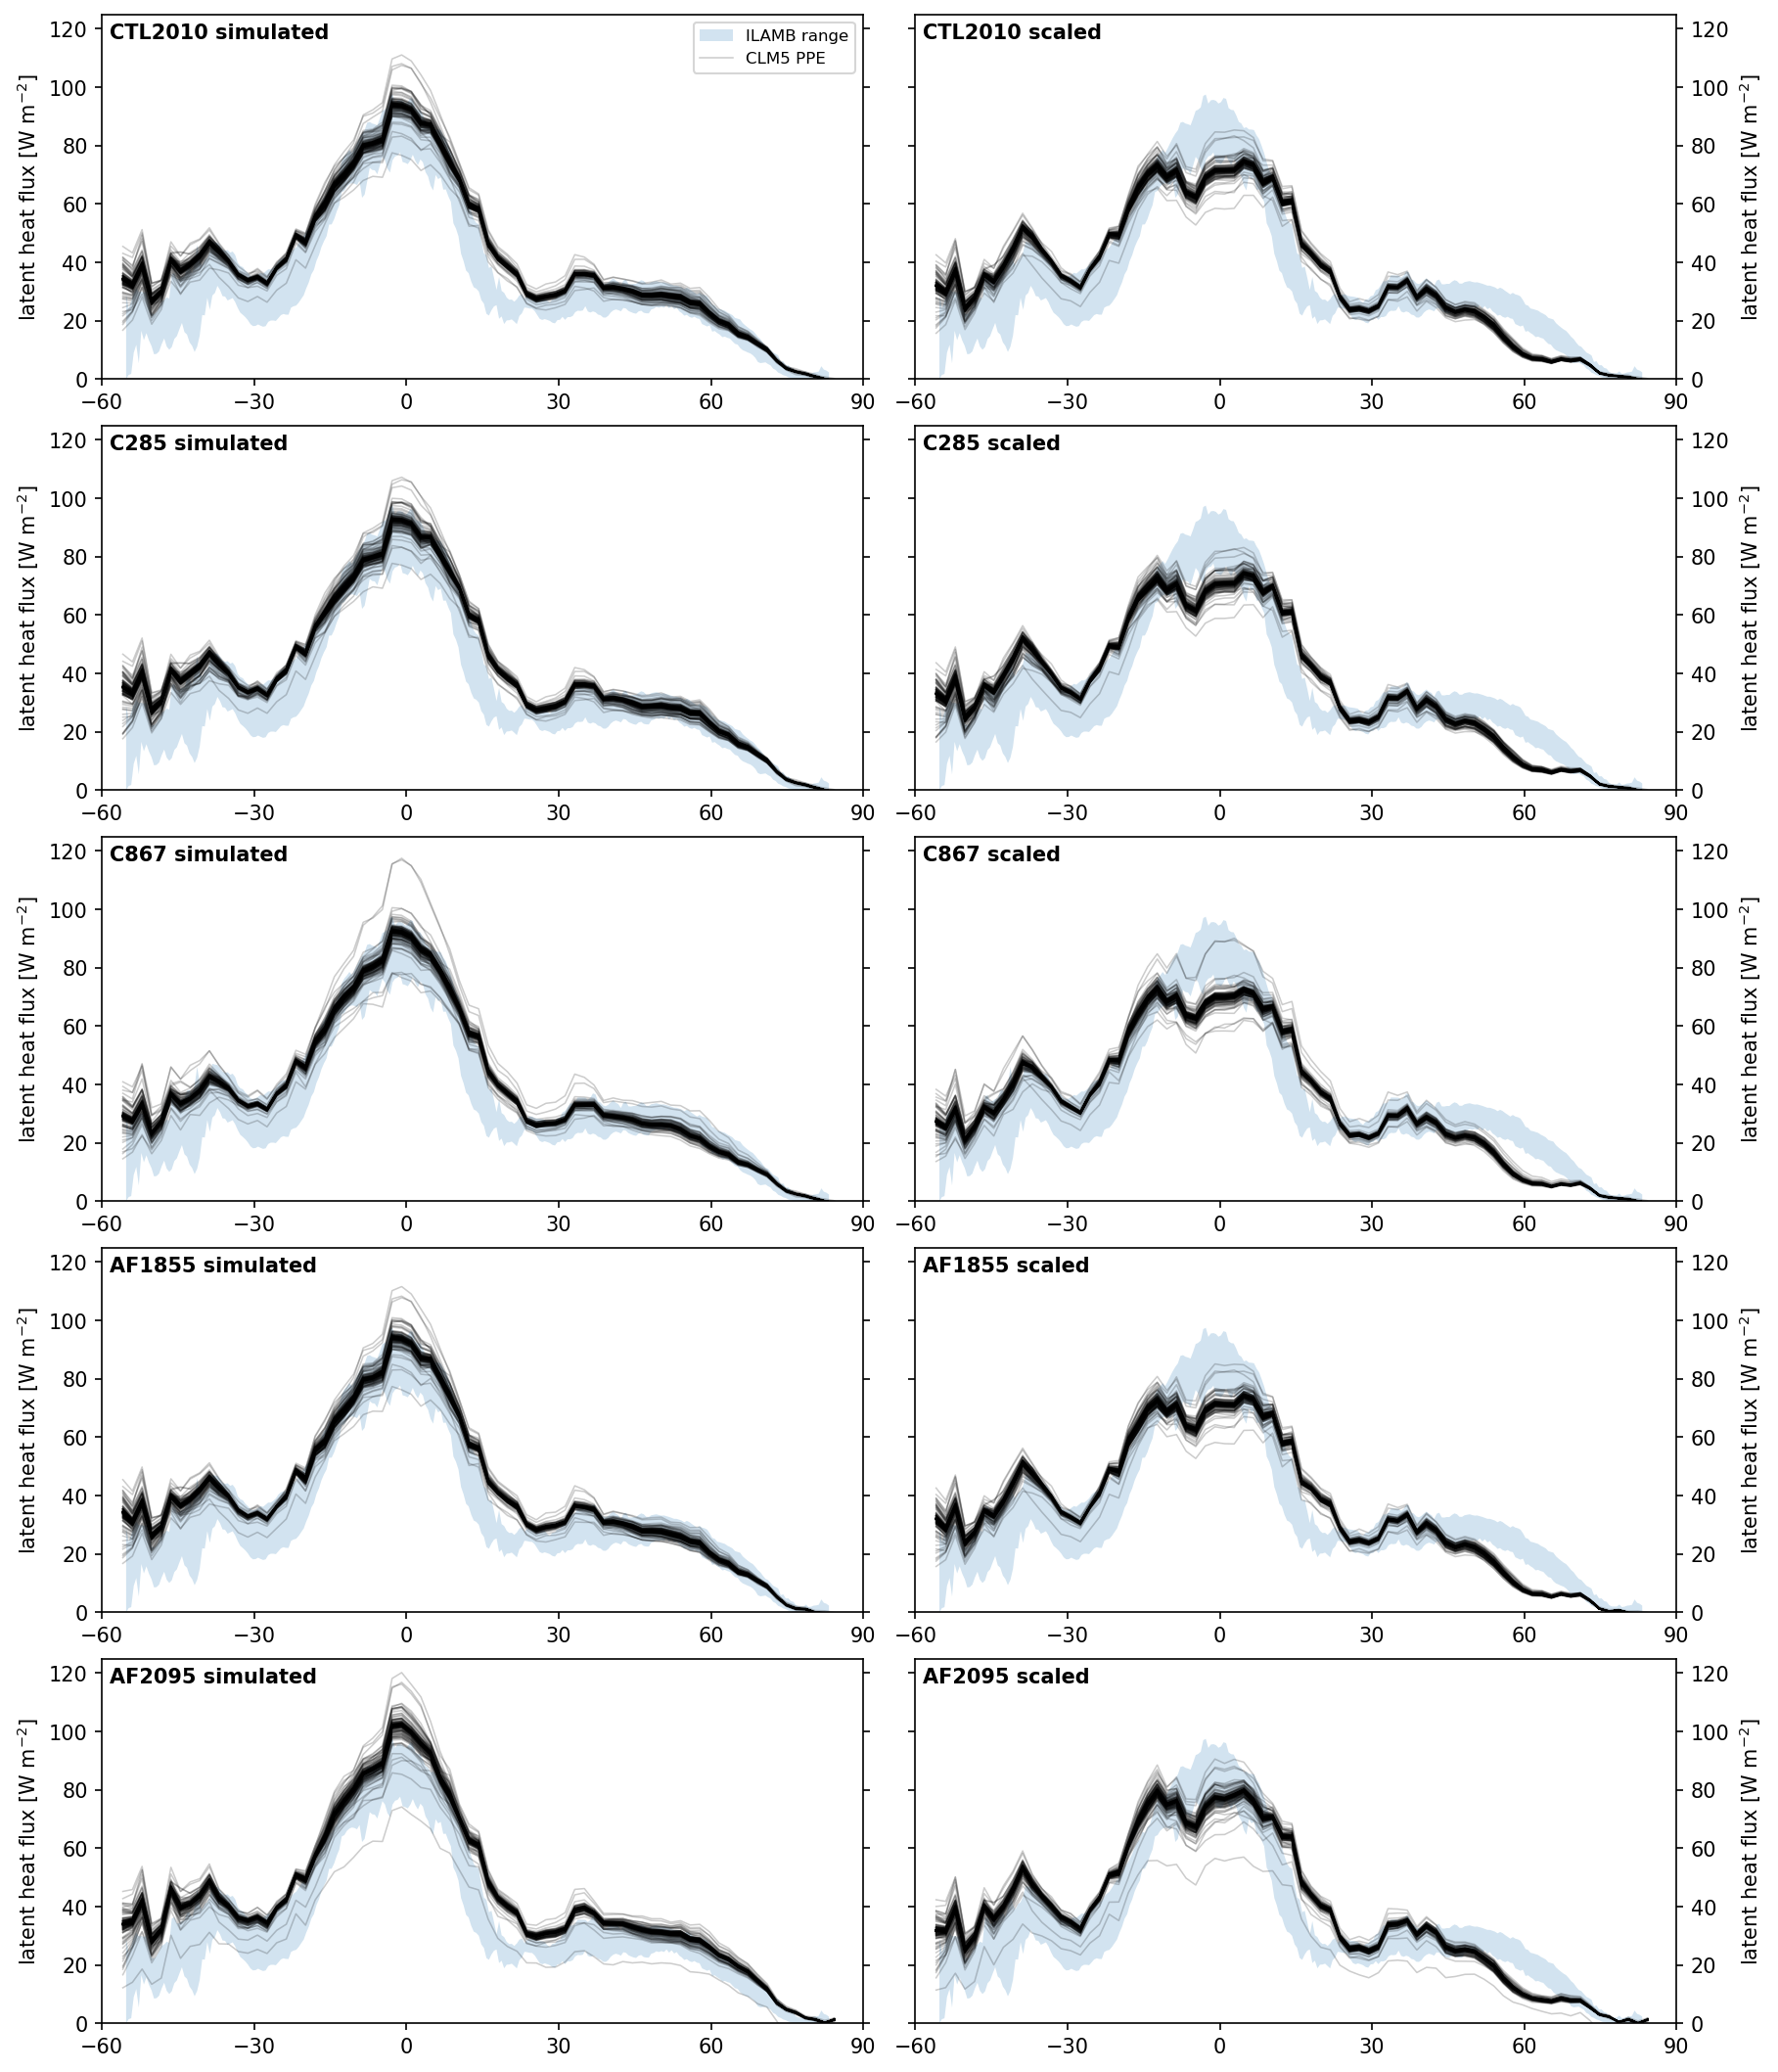

In [ ]:
plot_quantiles = False

fig, axs = plt.subplots(5, 2, figsize=(12, 14), sharex=False, sharey=True, layout='constrained')
ax = axs.flatten()

# Get the ILAMB min-max range
ilamb_max = ilamb_zm.max(dim='dataset')
ilamb_min = ilamb_zm.min(dim='dataset')

# CLM5 PPE forcings
forcing = clm5_scaled['gr_zm']['EFLX_LH_TOT_gridded_mean'].exp
forcing = [f.item() for f in forcing if f!='NDEP']

# CLM5 PPE parameters
param = clm5_scaled['gr_zm']['EFLX_LH_TOT_gridded_mean'].param.values

for i, forc in enumerate(forcing):
    for j, (kind, label) in enumerate(zip(['gr_zm', 'sc_zm'], ['simulated', 'scaled'])):
        # Plot the ILAMB min-max range
        axs[i, j].fill_between(
            ilamb_zm.lat, ilamb_min, ilamb_max,
            color='tab:blue', alpha=0.2, linewidth=0,
            label='ILAMB range')
        
        # Select the CLM5 PPE data
        if kind=='gr_zm': tag = ''
        else: tag = '_scaled'
        da = clm5_scaled[kind]['EFLX_LH_TOT_gridded_mean'+tag].sel(exp=forc).stack(ensemble=['param', 'minmax'])

        # Plot the CLM5 PPE quantiles, min, and max
        if plot_quantiles:
            defqs = [0.005, 0.01, 0.05, 0.95, 0.99, 0.995]
            qs = np.zeros((len(defqs), len(da.lat)))
            for k, q in enumerate(defqs):
                qs[k] = da.quantile(q, dim='ensemble', skipna=True).values;
            qmin = da.min(dim='ensemble')
            qmax = da.max(dim='ensemble')

            for k in range(int(len(defqs)/2)):
                if k == 0:
                    axs[i, j].fill_between(
                        da.lat, qs[k], qs[-k-1],
                        color='red', alpha=0.2, lw=0,
                        label=f'PPE quantile ranges\n(0.05-0.95, 0.01-0.99, 0.005-0.995)')
                else:
                    axs[i, j].fill_between(
                        da.lat, qs[k], qs[-k-1],
                        color='tab:red', alpha=0.5, lw=0)
            axs[i, j].plot(da.lat, qmin, color='red', lw=1, ls=':', label='PPE extrema')
            axs[i, j].plot(da.lat, qmax, color='red', lw=1, ls=':')

        # Plot the CLM5 PPE ensemble members
        if not plot_quantiles:
            for ens in da.ensemble:
                da_ens = da.sel(ensemble=ens)
                if da_ens.isel(lat=0).minmax == 'min' and da_ens.isel(lat=0).param == 'default':
                    da_ens.plot(
                        ax=axs[i, j], color='black', alpha=0.2, lw=0.75,
                        label='CLM5 PPE', _labels=False)
                    
                else:
                    da_ens.plot(
                        ax=axs[i, j], color='black', alpha=0.2, lw=0.75,
                        label=None, _labels=False)
        
        # Format the y-axis
        axs[i, j].set_ylim(0, 125)
        if j == 1:
            axs[i, j].yaxis.set_label_position('right')
            axs[i, j].tick_params(axis='y', labelright=True)
        axs[i, j].yaxis.set_ticks_position('both')
        axs[i, j].set_ylabel('latent heat flux [W m$^{-2}$]')
        
        # Format the x-axis
        axs[i, j].set_xlim(-60, 90)
        axs[i, j].set_xticks([-60, -30, 0, 30, 60, 90])

        # Add a title
        axs[i, j].text(
            0.01, 0.975, f'{forc} {label}',
            ha='left', va='top', transform=axs[i, j].transAxes,
            fontsize=10, fontweight='bold'
        )

        # Add a legend
        if i == 0 and j == 0:
            axs[i, j].legend(loc='upper right', fontsize=8)

# if not plot_quantiles:
#     fig.savefig('./ilamb/clm5_ppe_ilamb_zonal_indv.png', bbox_inches='tight', dpi=400)
# if plot_quantiles:
#     fig.savefig('./ilamb/clm5_ppe_ilamb_zonal_quant.png', bbox_inches='tight', dpi=400)